# Artificial Neural Network for Heating Load

In [1]:
import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import validation_curve

%matplotlib inline  

### Preprocessing

In [2]:
dataframe_all=pd.read_csv('ENB2012.csv')
dataframe_all.Y1 = dataframe_all.Y1.round()
dataframe_all.Y2 = dataframe_all.Y2.round()

x = dataframe_all.iloc[:,:-2].values
#Extracting the outputs for HeatLoad and ColdLoad.
y1_HL=dataframe_all.iloc[:,-2].values.ravel()
y2_CL=dataframe_all.iloc[:,-1].values.ravel()
print("Shape x:  {}     Shape y1_HL: {}  Shape y2_CL: {}".format(x.shape, y1_HL.shape,y2_CL.shape)) 

Shape x:  (768, 8)     Shape y1_HL: (768,)  Shape y2_CL: (768,)


### Scaling

In [3]:
# 25% for Test Size  -  Seed=0 For debugging.
X_train, X_test, y_train, y_test = train_test_split(x, y1_HL,random_state=0)
# Split for Validation and Trainning Set.
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train,random_state=0)
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#Normalization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



## Grid Search for Hidden Neurons and Learning Rate

In [168]:
#Find Learning Rate
param_grid = [{'hidden_layer_sizes':[10,50,100,200],
               'learning_rate_init':[0.5,0.1,0.01,0.001] }]

print("Parameter grid:\n{}".format(param_grid))


Parameter grid:
[{'learning_rate_init': [0.5, 0.1, 0.01, 0.001], 'hidden_layer_sizes': [10, 50, 100, 200]}]


In [193]:
grid_search = GridSearchCV(MLPClassifier(
                        solver='sgd',               
                        learning_rate='constant',                        
                        early_stopping = True,                        
                        momentum=.9,
                        alpha=1e-5,
                        random_state=0,
                         
                        )
                           , param_grid, cv=kfold, scoring='neg_mean_squared_error')

grid_search.fit(X_train_scaled, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))


Best parameters: {'learning_rate_init': 0.5, 'hidden_layer_sizes': 50}
Best cross-validation score: -13.15
Test set score: -7.95


### Heatmap

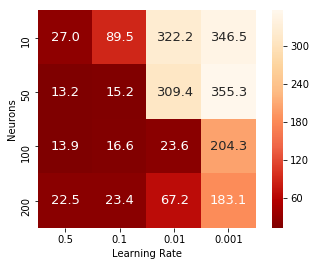

In [194]:
results = pd.DataFrame(grid_search.cv_results_)
scores = grid_search.cv_results_['mean_test_score'].reshape(len(param_grid[0]['learning_rate_init']), len(param_grid[0]['hidden_layer_sizes']))
import seaborn as sns
ax = sns.heatmap(
    np.abs(scores),
    cmap="OrRd_r",
    cbar=True,
    annot=True,
    square=True,
    fmt='.1f',
    yticklabels=(param_grid[0]['hidden_layer_sizes']),
    xticklabels=(param_grid[0]['learning_rate_init']),
    annot_kws={'size': 13})
plt.xlabel('Learning Rate')
plt.ylabel('Neurons')
plt.savefig("./plots/ANN/Y1/heatmap_Y1HL.png", dpi=300, bbox_inches='tight') # save as png
plt.show()
sns.reset_orig()

## Regularization.

PLOT the MSE on the training and validation set as a function of lambda
(this is the regularization graph) and find the optimal lambda.


C:\Users\Diego\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


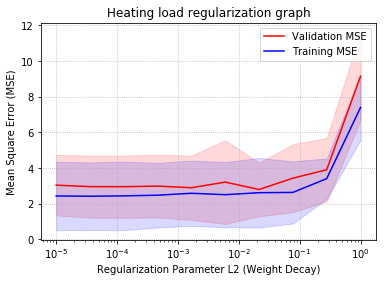

In [4]:
param_range = np.logspace(-5, 0, 10)
train_scores, test_scores = validation_curve(
                                                estimator=MLPClassifier(
                                                                                        solver='sgd',                                                                                                       
                                                                                        learning_rate='constant',                        
                                                                                        early_stopping = False,
                                                                                        learning_rate_init= 0.5,
                                                                                        hidden_layer_sizes=(50,),
                                                                                        momentum=.9, 
                                                                                        random_state=0,

                                                                                        ),
                                                X=X_train_scaled,
                                                y=y_train,
                                                param_name="alpha",
                                                param_range=param_range,
                                                scoring='neg_mean_squared_error',
                                                cv=5)
train_scores = np.abs(train_scores)
test_scores = np.abs(test_scores)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, test_mean,
    color='red',    
    label='Validation MSE')
plt.fill_between(param_range,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15, color='red')
plt.plot(param_range, train_mean,
    color='blue',   
    label='Training MSE')
plt.fill_between(param_range, train_mean + train_std,
    train_mean - train_std, alpha=0.15,
    color='blue')
#plt.xticks(rotation=45)
plt.xscale('log')
plt.legend(loc=0, fontsize =10)
plt.title("Heating load regularization graph")
plt.grid(linestyle='dotted')
plt.xlabel("Regularization Parameter L2 (Weight Decay)")
plt.ylabel('Mean Square Error (MSE)')
#plt.xlim([1e-5, 10])
#plt.ylim([0, 20])
plt.savefig("./plots/ANN/Y1/validation_curve_Y1HL.png", dpi=300, bbox_inches='tight') # save as png
plt.show()

## Early Stopping

In [199]:
from sklearn.base import clone
#split the data again.
#Normalization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_val_scaled = scaler.transform(X_train_val)
X_test_val_scaled = scaler.transform(X_test_val)


minimum_val_error = float("inf")
best_epoch = None
best_model = None
y_MSE_trainning = []
y_MSE_validation= []
x_epochs=[]

clf = MLPClassifier(solver='sgd',
                        max_iter=1,
                        hidden_layer_sizes=(50,),
                        batch_size=X_train_val.shape[0],
                        learning_rate='constant',
                        learning_rate_init= .1,
                        early_stopping = False,
                        momentum=.9,
                        warm_start=True,
                        alpha=1e-05,
                        random_state=0)
              
for epoch in range(200):
    clf.fit(X_train_val_scaled, y_train_val) # continues where it left off
    
    x_epochs.append(epoch)

    y_pred_train  = clf.predict(X_train_val_scaled)
    y_pred_val    = clf.predict(X_test_val_scaled)
    
    MSE_train = mean_squared_error(y_train_val, y_pred_train)
    MSE_val       = mean_squared_error(y_test_val, y_pred_val)
    
    y_MSE_validation.append(MSE_val)
    y_MSE_trainning.append(MSE_train)
    
    
    if MSE_val < minimum_val_error:
        minimum_val_error = MSE_val
        best_epoch = epoch
        

C:\Users\Diego\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


PLOT a graph of the mean square error (MSE) as a function of training
epochs. Plot on the same graph the MSE for the validation set.

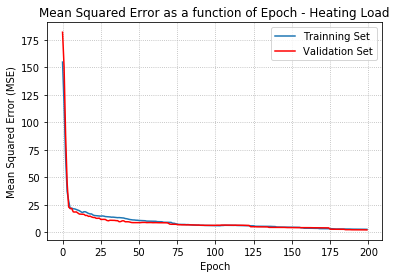

In [200]:
plt.figure(figsize=(6,4))

plt.plot(x_epochs,y_MSE_trainning, label='Trainning Set')
plt.plot(x_epochs,y_MSE_validation, color='r',label='Validation Set')
         
plt.title('Mean Squared Error as a function of Epoch - Heating Load')  
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend(loc='best', fontsize =10)
plt.grid(linestyle='dotted')
plt.savefig("./plots/ANN/Y1/error_vs_epoch_Y1HL.png", dpi=300, bbox_inches='tight') # save as png
plt.show()

# Final Model

In [ ]:
MSE_test_list =[]
MSE_train_list =[]
MSE_val_list=[]

#Run for 20 times.
for i in range(1,21):
    X_train, X_test, y_train, y_test = train_test_split(x, y1_HL) #Heating Load
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)    
    kfold = KFold(n_splits=5, shuffle=True)
    
    mpl= MLPClassifier(
                        solver='sgd',
                        hidden_layer_sizes=(50,),
                        learning_rate='constant',
                        learning_rate_init= 0.1,
                        early_stopping = False,
                        momentum=.9,
                        alpha=1e-05
                        ) 
    scores = cross_validate(mpl, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=kfold, return_train_score=True)
    
    MSE_val_list.append(np.mean(np.abs(scores['test_score'])))
    MSE_train_list.append(np.mean(np.abs(scores['train_score'])))
    
    mpl.fit(X_train_scaled, y_train)
    y_pred_test = mpl.predict(X_test_scaled)

    MSE_test=mean_squared_error(y_test, y_pred_test)
    MSE_test_list.append(MSE_test)

    
print("Test Set MSE:               {:.2f}±{:.2f}".format(np.mean(MSE_test_list),np.std(MSE_test_list)))
print("Train Set MSE:              {:.2f}±{:.2f}".format(np.mean(MSE_train_list),np.std(MSE_train_list)))
print("Validation Set MSE:         {:.2f}±{:.2f}".format(np.mean(MSE_val_list),np.std(MSE_val_list)))


In [202]:
mpl

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.1, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

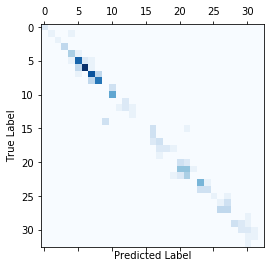

In [207]:
from sklearn.metrics import confusion_matrix
conf_mx=confusion_matrix(y_test, y_pred_test)
plt.matshow(conf_mx, cmap=plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel('True Label')
plt.savefig("./plots/ANN/Y1/confusion_matrix_Y1HL.png", dpi=300, bbox_inches='tight') # save as png
plt.show()

In [208]:
from sklearn.metrics import classification_report
target_names = np.unique(y_test).astype(int).astype(np.str)
print(classification_report(y_test, y_pred_test, target_names=None))

             precision    recall  f1-score   support

        6.0       1.00      1.00      1.00         2
        7.0       1.00      0.50      0.67         2
        8.0       1.00      1.00      1.00         1
       10.0       1.00      1.00      1.00         4
       11.0       0.71      0.83      0.77         6
       12.0       0.67      0.75      0.71        16
       13.0       0.88      0.75      0.81        20
       14.0       0.68      0.72      0.70        18
       15.0       0.73      0.73      0.73        15
       16.0       0.00      0.00      0.00         3
       17.0       0.73      1.00      0.84         8
       18.0       0.00      0.00      0.00         2
       19.0       0.50      0.50      0.50         4
       20.0       0.50      1.00      0.67         1
       21.0       0.00      0.00      0.00         3
       23.0       0.00      0.00      0.00         4
       24.0       0.38      1.00      0.55         3
       25.0       0.50      0.60      0.55   

C:\Users\Diego\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
